In [1]:
import torch
import umap
import random
import itertools
import numpy as np
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from dataset.NCI1_dataset import NCI1
from tqdm import trange
from sklearn.model_selection import train_test_split

from models.GraphESN import GraphESN

from DMD.dmd import KANN

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset = TUDataset(root='dataset/MUTAG', name='MUTAG')
dataset = NCI1('dataset/NCI1/')
input_size = dataset[0]['x'].shape[1]

In [3]:
len(dataset)

500

In [4]:
dataset[0]

Data(x=[21, 37], edge_index=[2, 46], y=[1], z=[21], idx=[1])

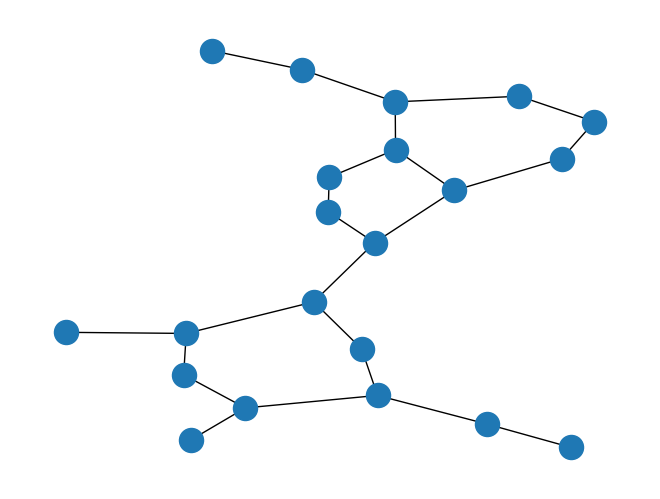

In [8]:
edge_index = dataset[0]['edge_index']
x = dataset[0]['x']
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [6]:
dataset[0]['y']

tensor([1])

In [9]:
model = GraphESN(input_size=input_size,
                hidden_size=70,
                steps=100,
                input_scaling=1.,
                num_layers=1,
                leaking_rate=0.8,
                spectral_radius=0.6,
                density=0.3,
                activation='tanh',
                alpha_decay=False)


In [10]:
embs = []
for g in dataset:
    embs.append(model(g['x'], g['edge_index']).mean(dim=0))
embs = torch.stack(embs).to(device)

torch.save(embs, 'GESN/embeddings_NCI1.pt')

In [4]:
embs = torch.load('GESN/embeddings_NCI1.pt')

In [11]:
embs.shape

torch.Size([500, 70])

In [12]:
states = []
for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim
    states.append(state.cpu())

norm = []

for s in states:
    norm.append(torch.linalg.vector_norm(s[:,:-1,:]-s[:,1:,:], dim=(0,2)))

l = 100
for n in norm:
    l = n.shape[0] if n.shape[0]<l else l

for i in range(len(norm)):
    norm[i] = norm[i][:l]

norm = torch.stack(norm)

m_norm = norm.mean(dim=0)
s_norm = norm.std(dim=0)

In [13]:
state.shape

torch.Size([1, 101, 3710])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


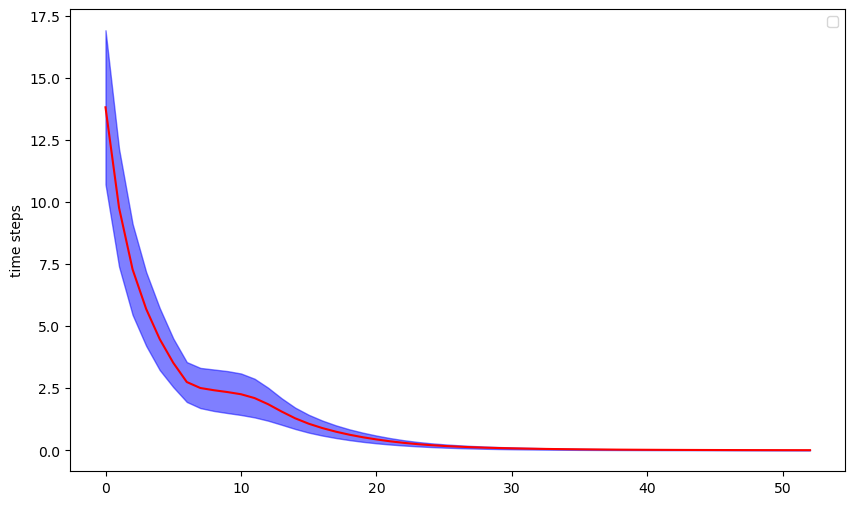

In [14]:
plt.figure(figsize=(10,6))
t = np.linspace(0, norm.shape[1]-1, norm.shape[1])
plt.plot(t, m_norm, color='r')
plt.fill_between(t, m_norm-s_norm, m_norm+s_norm, color='b', alpha=0.5)
plt.ylabel('time steps')
plt.legend()
plt.show()

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(embs.cpu())

Text(0.5, 1.0, 'UMAP projection')

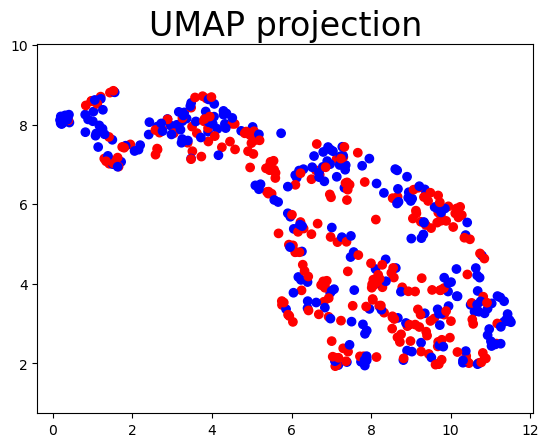

In [16]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=['b' if x['y']==0 else 'r' for x in dataset])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [29]:
check = 0
for i in range(len(dataset)):
    check += dataset[i]['y']

In [31]:
check / len(dataset)

tensor([0.5160])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(embs, dataset.y, test_size=0.3)#, random_state=seed)

In [18]:
y_test.sum() / y_test.shape[0]

tensor(0.5133)

In [19]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(model.hidden_size, 2)
    ).to(device)

In [20]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.027)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 300
classifier.train()
losses, loss_e = [], []

for epoch in trange(epochs):
    for x, y in zip(X_train, y_train):
        out = classifier(x)
        optimizer.zero_grad()
        loss = loss_fn(out, y.type(torch.LongTensor).squeeze().to(device))
        loss.backward()
        optimizer.step()
        loss_e.append(loss.clone().detach())
    losses.append(torch.tensor(loss_e).mean())

100%|██████████| 300/300 [08:28<00:00,  1.70s/it]


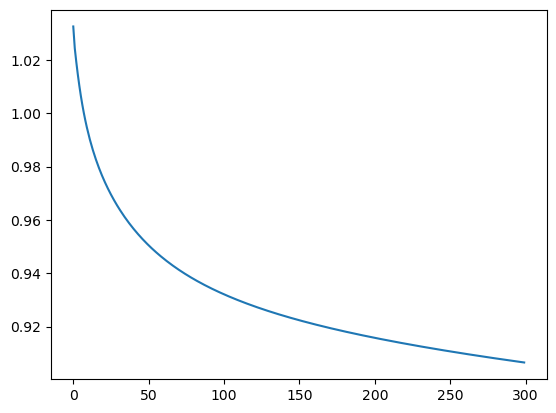

In [21]:
plt.plot(torch.tensor(losses).detach().cpu().numpy())

In [22]:
classifier.eval()
test_acc = (classifier(X_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(test_acc)

tensor(0.6200)


## Global Koopman analysis

In [44]:
koops = []
states = []
dim_red = 15 # < l
method = "TruncatedSVD"

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:dim_red+1], dim=1)
    state = torch.sum(state, dim=0)
    states.append(state)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute local Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    koops.append(C.flatten())

koops = torch.from_numpy(np.stack(koops)).to(device)

states = torch.stack(states, dim=0)

In [45]:
# compute global Koopman operator
kann_global = KANN(states.cpu(), k=15, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                    # k <= steps
C_global = kann_global.compute_KOP()

In [55]:
E_global, V_global = np.linalg.eig(C_global)

idx = E_global.argsort()[::-1]   
E_global = E_global[idx]
V_global = V_global[:,idx]

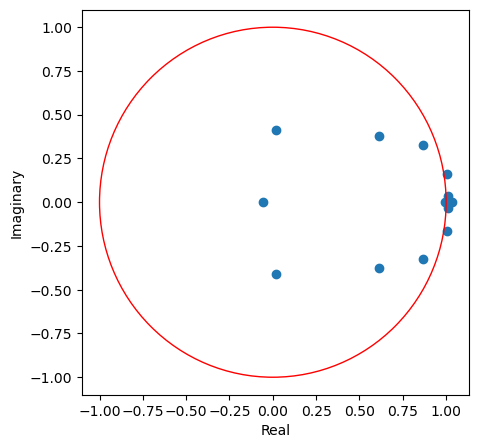

In [56]:
plt.figure(figsize=(5,5))
plt.scatter(E_global.real, E_global.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

Check projection of graph state onto most important eigenvector of C

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Projection on main eigenvector of C')

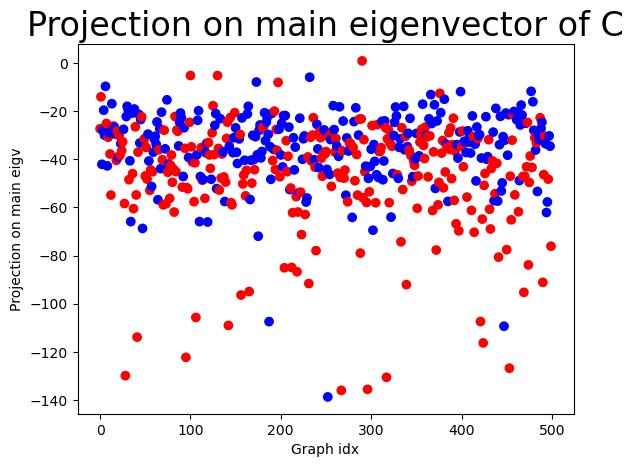

In [129]:
last_state_transf = kann_global.emb_engine.transform(states[:,-1,:])
proj = last_state_transf @ V_global[:,0]

plt.scatter(
    [i for i in range(proj.shape[0])],
    proj,
    c=['b' if x['y']==0 else 'r' for x in dataset])
plt.gca().set_aspect('auto', 'datalim')
plt.xlabel('Graph idx')
plt.ylabel('Projection on main eigv')
plt.title('Projection on main eigenvector of C', fontsize=24)

[[1.        +0.j 0.01697381+0.j]
 [0.01697381+0.j 1.        +0.j]]


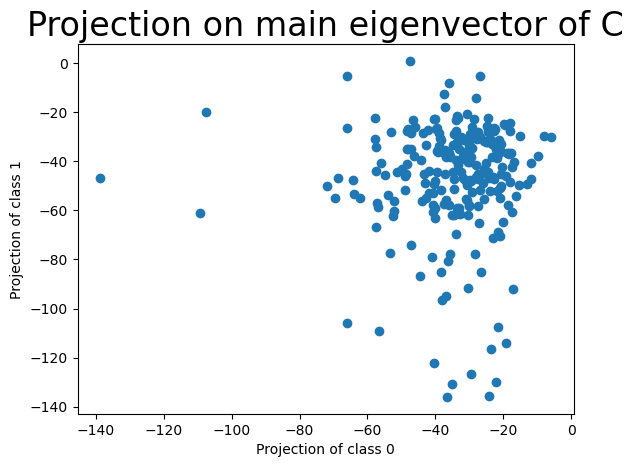

In [130]:
proj_c0, proj_c1 = [], []

for i in range(proj.shape[0]):
    if dataset[i]['y']==0:
        proj_c0.append(proj[i])
    else:
        proj_c1.append(proj[i])

proj_c0 = np.array(proj_c0)
proj_c1 = np.array(proj_c1)

plt.scatter(proj_c0, proj_c1[:242])
plt.gca().set_aspect('auto', 'datalim')
plt.xlabel('Projection of class 0')
plt.ylabel('Projection of class 1')
plt.title('Projection on main eigenvector of C', fontsize=24)

print(np.corrcoef(proj_c0, proj_c1[:242]))

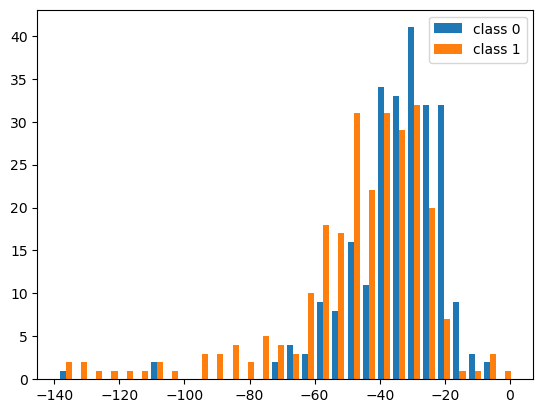

In [136]:
plt.hist([proj_c0, proj_c1], bins=30, label=['class 0', 'class 1'])
plt.legend()
plt.show()

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Projection on two main eigenvectors of C')

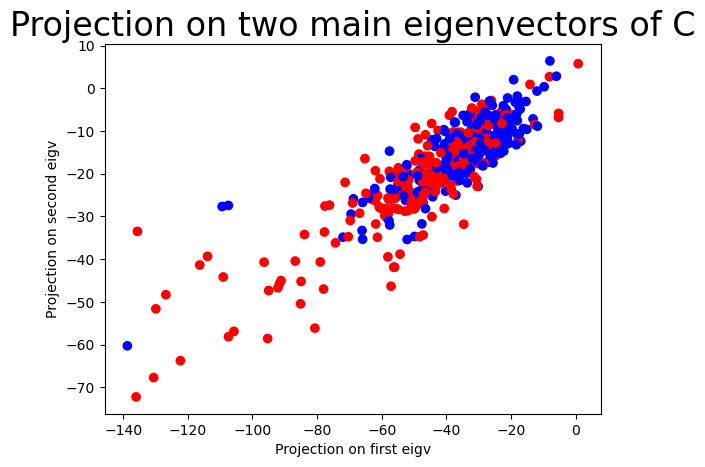

In [137]:
proj1 = last_state_transf @ V_global[:,0]
proj2 = last_state_transf @ V_global[:,1]

plt.scatter(
    proj1,
    proj2,
    c=['b' if x['y']==0 else 'r' for x in dataset])
plt.gca().set_aspect('auto', 'datalim')
plt.xlabel('Projection on first eigv')
plt.ylabel('Projection on second eigv')
plt.title('Projection on two main eigenvectors of C', fontsize=24)

Correlation between classes considering more eigenvalues:

In [138]:
proj_tot = last_state_transf @ V_global

proj_c0, proj_c1 = [], []

for i in range(proj.shape[0]):
    if dataset[i]['y']==0:
        proj_c0.append(proj_tot[i,:])
    else:
        proj_c1.append(proj_tot[i,:])

proj_c0 = np.array(proj_c0)
proj_c1 = np.array(proj_c1)[:242,:]


In [139]:
corr_matrix_abs = np.zeros(shape=(proj_c0.shape[1],proj_c0.shape[1]))
corr_matrix_ang = np.zeros(shape=(proj_c0.shape[1],proj_c0.shape[1]))

for i, j in itertools.product(range(proj_c0.shape[1]), range(proj_c1.shape[1])):
    corr_matrix_abs[i,j] = np.absolute(np.corrcoef(proj_c0[:,i], proj_c1[:,j])[0,1])
    corr_matrix_ang[i,j] = np.mod(np.angle(np.corrcoef(proj_c0[:,i], proj_c1[:,j])[0,1]), np.pi/2)

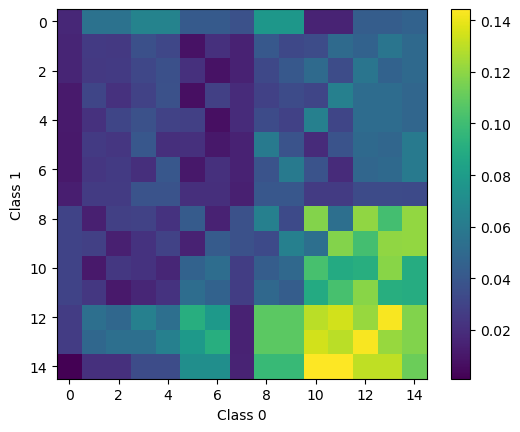

In [140]:
plt.imshow(corr_matrix_abs)
plt.xlabel('Class 0')
plt.ylabel('Class 1')
plt.colorbar()

They are all very low. I can't see from here negative correlations, because I take the absolute value.

Assuming that the highest values (the yellow part, which is not very high anyway) depicts a negative correlation, hten it seems that the least important eigenvectors are discriminating between classes, not the most important ones.

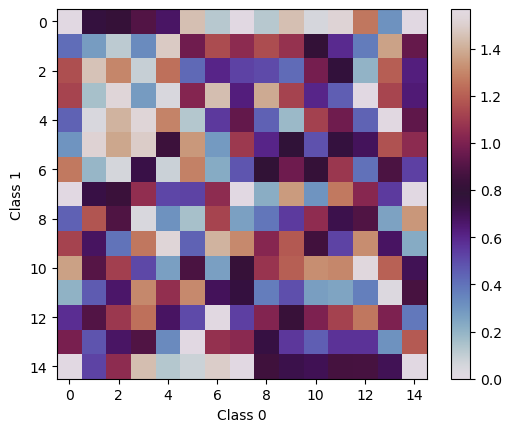

In [142]:
plt.imshow(corr_matrix_ang, cmap='twilight')
plt.xlabel('Class 0')
plt.ylabel('Class 1')
plt.colorbar()

Darker color means more different angles, but I can't intepret this

## Difference between global and local dynamics

per ogni grafo voglio proiettare l'ultimo stato (compresso a dim 15) sull'autovettore più importante dell'operatore diff_C, e controllare se ci sono differenze tra le due classi

In [118]:
C_local = koops.unflatten(dim=1, sizes=(dim_red,dim_red)).cpu().numpy()

In [119]:
diff_C = C_local - C_global

In [116]:
C_global.shape

(15, 15)

In [120]:
diff_C.shape

(500, 15, 15)

In [123]:
eigs, eigv = [], []

for c in diff_C:
    E_diff, V_diff = np.linalg.eig(c)

    idx = E_diff.argsort()[::-1]   
    E_diff = E_diff[idx]
    V_diff = V_diff[:,idx]

    eigs.append(E_diff[0])
    eigv.append(V_diff[:,0])

eigs = np.stack(eigs)
eigv = np.stack(eigv)

In [126]:
states.shape

torch.Size([500, 15, 70])

In [124]:
eigs.shape

(500,)

In [125]:
eigv.shape

(500, 15)

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(E_global.real, E_global.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

## Fit Koopman operator: linear terms only

In [25]:
koops = []
states = []
dim_red = 10 # < l
method = "TruncatedSVD"

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:11], dim=1)
    state = torch.sum(state, dim=0)
    states.append(state)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute local Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    koops.append(C.flatten())

koops = torch.from_numpy(np.stack(koops)).to(device)

states = torch.stack(states, dim=0)


In [31]:
# compute global Koopman operator
kann_ = KANN(states.cpu(), k=10, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                    # k <= steps
C_global = kann_.compute_KOP()

In [27]:
states.shape

torch.Size([500, 10, 77])

In [32]:
C_global.shape

(10, 10)

In [29]:
koops.shape

torch.Size([500, 100])

In [30]:
torch.save(koops, f"KOP/{method}_{dim_red}.pt")

### Train classifier on Koopman operator

In [119]:
K_train, K_test, y_train, y_test = train_test_split(koops, dataset.y, test_size=0.3, random_state=seed)

In [120]:
state_classifier = torch.nn.Sequential(
    torch.nn.Linear(koops.shape[1], 2)
    ).to(device)

state_optimizer = torch.optim.Adam(state_classifier.parameters(), lr=0.00157)
loss_fn2 = torch.nn.CrossEntropyLoss()
epochs = 500
state_classifier.train()
losses2, loss_e2 = [], []

for epoch in trange(epochs):
    for k, y in zip(K_train, y_train):
        out = state_classifier(k)
        state_optimizer.zero_grad()
        loss2 = loss_fn2(out, y.type(torch.LongTensor).squeeze().to(device))
        loss2.backward()
        state_optimizer.step()
        loss_e2.append(loss2.clone().detach())
    losses2.append(torch.tensor(loss_e2).mean())

100%|██████████| 500/500 [08:13<00:00,  1.01it/s]


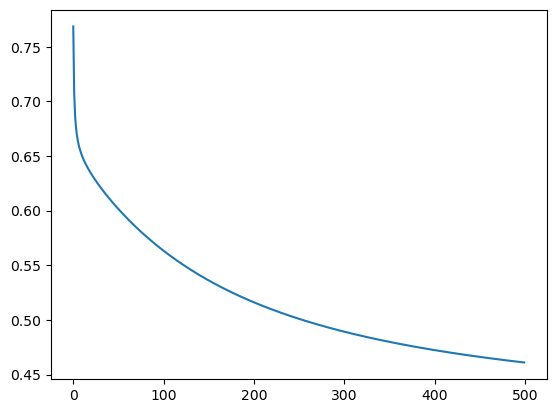

In [121]:
plt.plot(torch.tensor(losses2).detach().cpu().numpy())

In [122]:
state_classifier.eval()

state_test_acc = (state_classifier(K_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(f"Test accuracy: {state_test_acc}")

Test accuracy: 0.859649121761322


## Fit Koopman operator: quadratic terms

In [32]:
q_koops = []
dim_red = 5
method = "TruncatedSVD"

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0)
    state = torch.cat([state, state**2], dim=-1)

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method)    # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    q_koops.append(C.flatten())

q_koops = torch.from_numpy(np.stack(q_koops)).to(device)

In [33]:
q_koops.shape

torch.Size([188, 25])

In [34]:
torch.save(q_koops, f"KOP/quadr_{method}_{dim_red}.pt")

### Train classifier on Koopman operator (quadratic)

In [13]:
K_train, K_test, y_train, y_test = train_test_split(q_koops, dataset.y, test_size=0.3, random_state=seed)

100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


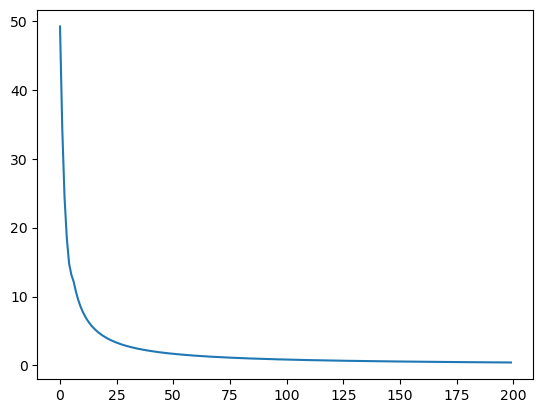

In [15]:
state_classifier = torch.nn.Sequential(
    torch.nn.Linear(q_koops.shape[1], 2)
    ).to(device)

state_optimizer = torch.optim.Adam(state_classifier.parameters(), lr=0.019)
loss_fn2 = torch.nn.CrossEntropyLoss()
epochs = 200
state_classifier.train()
losses2, loss_e2 = [], []

for epoch in trange(epochs):
    for k, y in zip(K_train, y_train):
        out = state_classifier(k)
        state_optimizer.zero_grad()
        loss2 = loss_fn2(out, y.type(torch.LongTensor).squeeze().to(device))
        loss2.backward()
        state_optimizer.step()
        loss_e2.append(loss2.clone().detach())
    losses2.append(torch.tensor(loss_e2).mean())

plt.plot(torch.tensor(losses2).detach().cpu().numpy())

In [16]:
state_classifier.eval()

state_test_acc = (state_classifier(K_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(f"Test accuracy: {state_test_acc}")

Test accuracy: 0.7719298005104065


# Explainability?

Difference between trajectory of (compressed) states and reconstruction of states via Koopman

In [60]:
dim_red = 5
method = "TruncatedSVD"
rec_traj = []
traj = []

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    traj.append(torch.from_numpy(kann_.Zp.squeeze()))
    rec_traj.append(torch.from_numpy(np.stack([C**n @ kann_.Zp.squeeze()[0,] for n in range(5)])))

In [65]:
norm = []
for i in range(len(traj)):
    norm.append(torch.linalg.vector_norm(traj[i]-rec_traj[i], dim=0))
norm = torch.stack(norm)
norm_m = norm.mean(dim=0)
norm_s = norm.std(dim=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


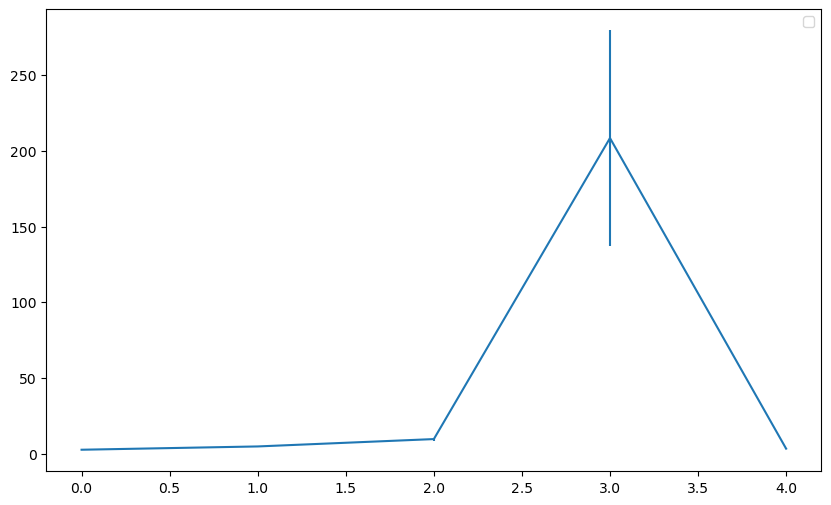

In [138]:
plt.figure(figsize=(10,6))
t = np.linspace(0, norm.shape[1]-1, norm.shape[1])
plt.errorbar(t, norm_m, yerr=norm_s)
plt.legend()
plt.show()

## Spectrum

Histogram of the spectrum

In [85]:
eigens, abs_eigens = [], []

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    D, _ = np.linalg.eig(C)
    eigens.append(D)
    abs_eigens.append(np.absolute(D))

eigens = np.concatenate(eigens)
abs_eigens = np.concatenate(abs_eigens)

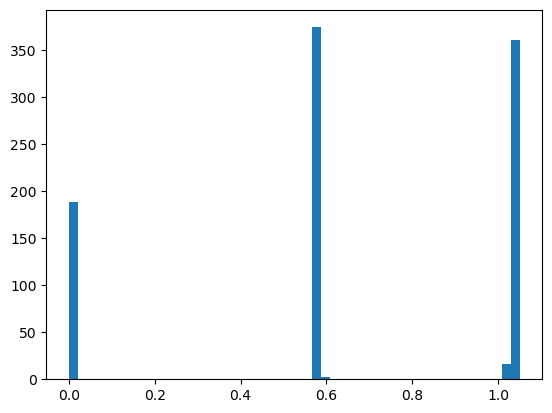

In [86]:
plt.hist(abs_eigens, bins=50)
plt.show()

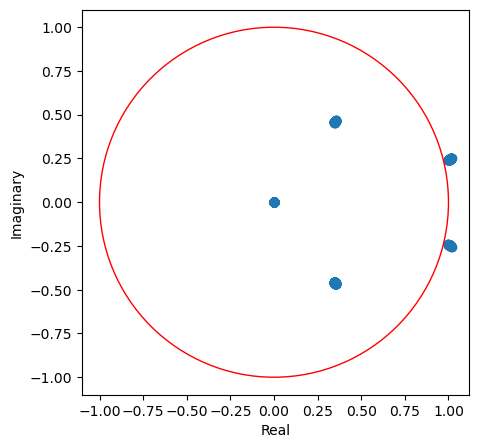

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(eigens.real, eigens.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

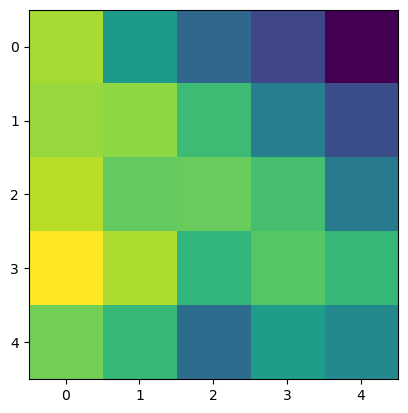

In [83]:
plt.imshow(np.log(np.abs(C)))

## Project on input

- perform SVD on states
- you get new states Zp with smaller dimensions
- find Koopman operator C that approximates Zp dynamics

In [88]:
# compute Koopman operator
C = kann_.compute_KOP() # last graph
D, V = np.linalg.eig(C)
U = np.linalg.inv(V)

In [89]:
np.allclose(C,(V @ np.diag(D) @ U)) # it should return True

True

In [90]:
kann_.Zp.shape

(1, 5, 5)

In [104]:
z = np.stack([C**n @ kann_.Zp.squeeze()[0,] for n in range(5)]) # reconstructed compressed states

Let's project states newZp onto the two most important eigenvectors

In [93]:
np.absolute(D)

array([1.0381122e+00, 1.0381122e+00, 5.7983375e-01, 5.7983375e-01,
       2.0944906e-09], dtype=float32)

In [107]:
scal0 = V[:,0].T @ z.T # scalar product with eigenvector
scal1 = V[:,1].T @ z.T # scalar product with eigenvector
proj = np.stack([V[:,0]*scal0[s] + V[:,1]*scal1[s] for s in range(len(scal0))]) # projection on eigenvector
proj = proj[np.newaxis, :, :] # add batch dim

In [126]:
proj.shape # batch, time steps, dim

(1, 5, 5)

In [ ]:
# Find output?
# state_classifier(torch.from_numpy(proj[:,-1,:]).type(torch.DoubleTensor).cuda())

Then we can recover the original sequence of states

In [111]:
recov = kann_.recover_states(proj.real, kann_.k)

In [113]:
recov.shape

(1, 5, 4576)

In [116]:
# recover the right shape
new_states = np.stack([recov.squeeze()[:,k*model.hidden_size:(k+1)*model.hidden_size] for k in range(recov.shape[-1]//model.hidden_size)], axis=1)
new_states = torch.tensor(new_states)

In [125]:
new_states.shape

torch.Size([5, 16, 286])

Can we plot the states back to the original graph?

In [131]:
imp = torch.softmax(torch.sum(new_states[-1,:,:],dim=-1),dim=0)
print(imp)

tensor([6.1498e-33, 7.8969e-33, 1.1976e-29, 8.1858e-02, 1.4503e-28, 8.1861e-02,
        5.7052e-27, 6.1425e-27, 3.5323e-08, 1.4194e-21, 8.3271e-01, 3.5715e-03,
        2.5432e-27, 1.0191e-14, 0.0000e+00, 0.0000e+00])


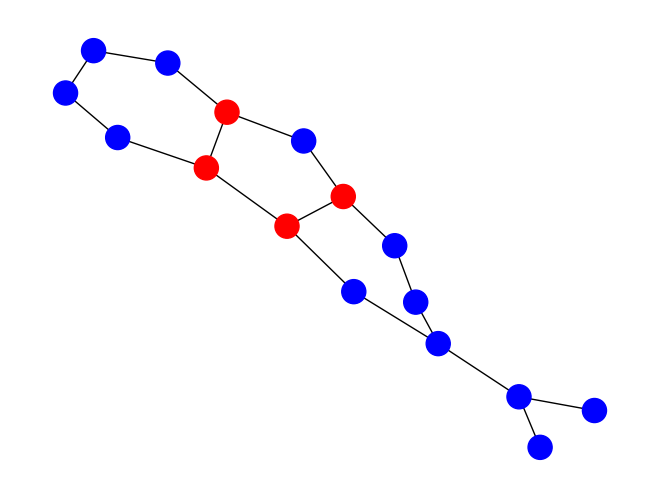

In [137]:
edge_index = dataset[-1]['edge_index'].cpu()
x = dataset[-1]['x'].cpu()
colors = ['r' if n>=0.001 else 'b' for n in imp]
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_color=colors)